In [1]:
import sys
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from transformers import PatchTSTConfig, PatchTSTForPrediction

path_root = '../anomaly_detection/'
sys.path.append(str(path_root))

from detectors import create_dataset

torch.set_default_dtype(torch.double)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/yizi/anaconda3/envs/timeinf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
block_length = 50
n_samples = 2000

bike_sharing = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True)
ts = bike_sharing['target'].to_numpy().reshape(-1,1)[:n_samples]
seq_len, n_dim = ts.shape

scaler = StandardScaler().fit(ts)
ts = scaler.transform(ts)
ts = ts.squeeze()

ts_train, ts_test = ts[:int(len(ts)*.8)], ts[int(len(ts)*.8):]
X_train, Y_train = create_dataset(ts_train, block_length=block_length, device=device)
X_train, Y_train = X_train[:,:,None], Y_train[:,-1,None,None]
X_test, Y_test = create_dataset(ts_test, block_length=block_length, device=device)
X_test, Y_test = X_test[:,:,None], Y_test[:,-1,None,None]
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

/home/yizi/TimeInf/baselines/../anomaly_detection/detectors.py:326: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(X).to(device), torch.tensor(Y).to(device)


torch.Size([1550, 50, 1]) torch.Size([1550, 1, 1])
torch.Size([350, 50, 1]) torch.Size([350, 1, 1])


In [3]:
# batch size = 1 otherwise TracIn will assign the same score to all time blocks in the batch
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
test_dataset = torch.utils.data.TensorDataset(X_train, Y_train)

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=1)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=1)

In [4]:
# https://huggingface.co/docs/transformers/en/model_doc/patchtst#transformers.PatchTSTConfig

config = PatchTSTConfig(
    num_input_channels=n_dim,         
    context_length=block_length,      # context length of the input sequence
    patch_length=5,                   # each patch is a token
    prediction_length=1,              # prediction horizon (one-step ahead in our setting)
    num_hidden_layers=1,
    d_model=16,
    num_attention_heads=1,
    ffn_dim=32,
    attention_dropout=0.,
    dropout=0.,
    random_mask_ratio=0.1,
    num_targets=1,
)

In [11]:
learning_rate = 0.01 
model = PatchTSTForPrediction(config).to(device)
# TracIn only works with SGD 
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
n_epochs = 50 # for demo purpose and increase as needed
weights = [] # use this to collect checkpoints

In [ ]:
for epoch in range(1, n_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # inputs: (bs, block_len, n_dim)
        # preds:  (bs, forecast_len, n_dim)
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(
            past_values=inputs,
            future_values=targets,
        )
        preds = outputs.prediction_outputs
        loss = nn.MSELoss()(targets, preds)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        
    print(f'epoch: {epoch} loss: {running_loss / len(train_loader):.5f}')
    
    running_loss = 0.0

print('Finished Training!')
torch.save(model.state_dict(), f'model_patchtst')

In [14]:
# validate patchTST
model.eval()
test_targets, test_preds = [], []
for i, data in enumerate(test_loader):
    inputs, targets = data
    inputs, targets = inputs.to(device), targets.to(device)

    outputs = model(
        past_values=inputs,
        future_values=targets,
    )
    preds = outputs.prediction_outputs
    test_targets.append(targets)
    test_preds.append(preds)
test_targets = torch.concat(test_targets).squeeze().cpu().detach().numpy()
test_preds = torch.concat(test_preds).squeeze().cpu().detach().numpy()

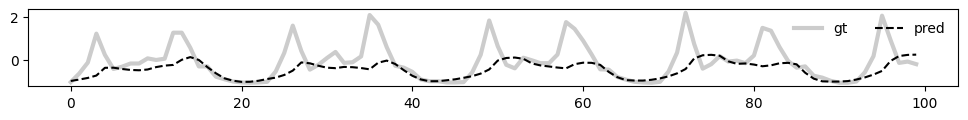

In [15]:
plt.figure(figsize=(12, 1))
plt.plot(test_targets[:100], c='k', linewidth=3, alpha=.2, label='gt')
plt.plot(test_preds[:100], c='k', linestyle='--', label='pred')
plt.legend(ncol=2, frameon=False)
plt.show()

In [32]:
from typing import Any, Dict, List, Optional, Union
import torch
from torch import nn
from kronfluence.task import Task
import math

class RegressionTask(Task):
    def compute_train_loss(
        self,
        batch: Any,
        model: nn.Module,
        sample: bool = False,
    ) -> torch.Tensor:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(
            past_values=inputs,
            future_values=targets,
        ).prediction_outputs
        if not sample:
            return F.mse_loss(outputs, targets, reduction="sum")
        # Sample the outputs from the model's prediction for true Fisher.
        with torch.no_grad():
            sampled_targets = torch.normal(outputs.detach(), std=math.sqrt(0.5))
        return F.mse_loss(outputs, sampled_targets, reduction="sum")

    def compute_measurement(
        self,
        batch: Any,
        model: nn.Module,
    ) -> torch.Tensor:
        return self.compute_train_loss(batch, model, sample=False)

    def get_influence_tracked_modules(self) -> Optional[List[str]]:
        return None  # Compute influence scores on all available modules.

    def get_attention_mask(self, batch: Any) -> Optional[Union[Dict[str, torch.Tensor], torch.Tensor]]:
        # TODO: [Optional] Complete this method.
        return None  # Attention mask not used.

In [45]:
from kronfluence.analyzer import Analyzer, prepare_model
task = RegressionTask()
model = prepare_model(model, task)

In [50]:
analyzer = Analyzer(
    analysis_name="test",
    model=model,
    task=task,
    cpu=False,
    disable_tqdm=False,
)

In [51]:
analyzer.fit_all_factors(factors_name="initial_factor", dataset=train_dataset)

/home/yizi/anaconda3/envs/timeinf/lib/python3.12/site-packages/kronfluence/factor/covariance.py:200: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(init_scale=factor_args.amp_scale, enabled=enable_grad_scaler)
Fitting covariance matrices [1/1] 100%|█████████████████████ [time left: 00:00, time spent: 00:00]
Performing Eigendecomposition [24/24] 100%|█████████████████ [time left: 00:00, time spent: 00:00]
/home/yizi/anaconda3/envs/timeinf/lib/python3.12/site-packages/kronfluence/factor/eigen.py:398: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(init_scale=factor_args.amp_scale, enabled=enable_grad_scaler)
Fitting Lambda matrices [1/1] 100%|█████████████████████████ [time left: 00:00, time spent: 00:00]


In [40]:
from kronfluence.arguments import ScoreArguments

score_args = ScoreArguments(
    compute_per_token_scores=False,
)

In [59]:
analyzer.compute_self_scores(
    scores_name="self_score",
    factors_name="initial_factor",
    train_dataset=train_dataset,
    overwrite_output_dir=True,
)
self_scores = analyzer.load_self_scores(scores_name="self_score")

/home/yizi/anaconda3/envs/timeinf/lib/python3.12/site-packages/kronfluence/score/self.py:205: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(init_scale=factor_args.amp_scale, enabled=enable_grad_scaler)
Computing self-influence scores [1/1] 100%|█████████████████ [time left: 00:00, time spent: 00:00]


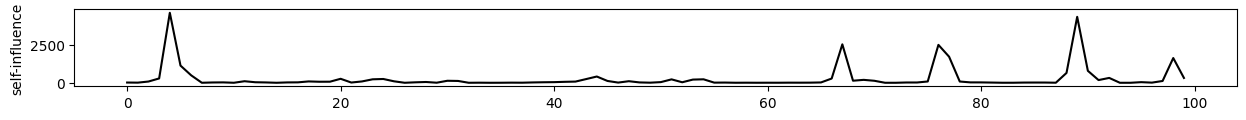

In [62]:
plt.figure(figsize=(15,1))
plt.plot(self_scores["all_modules"][100:200], c='k')
plt.ylabel('self-influence')
plt.show()